In [49]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [50]:
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(p=.30),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [61]:
train_data = datasets.CIFAR10(root='./Cifar10', train=True, download=True, transform=train_transform)
test_data = datasets.CIFAR10(root='./Cifar10', train=False, download=True, transform=test_transform)
image,labelIdx = train_data[10]
print(train_data.classes[labelIdx])

Files already downloaded and verified
Files already downloaded and verified
deer


In [64]:
num_workers = 0
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=num_workers)
print(len(train_loader.dataset), len(test_loader.dataset))
print(train_data.classes)

50000 10000
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [65]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor imag

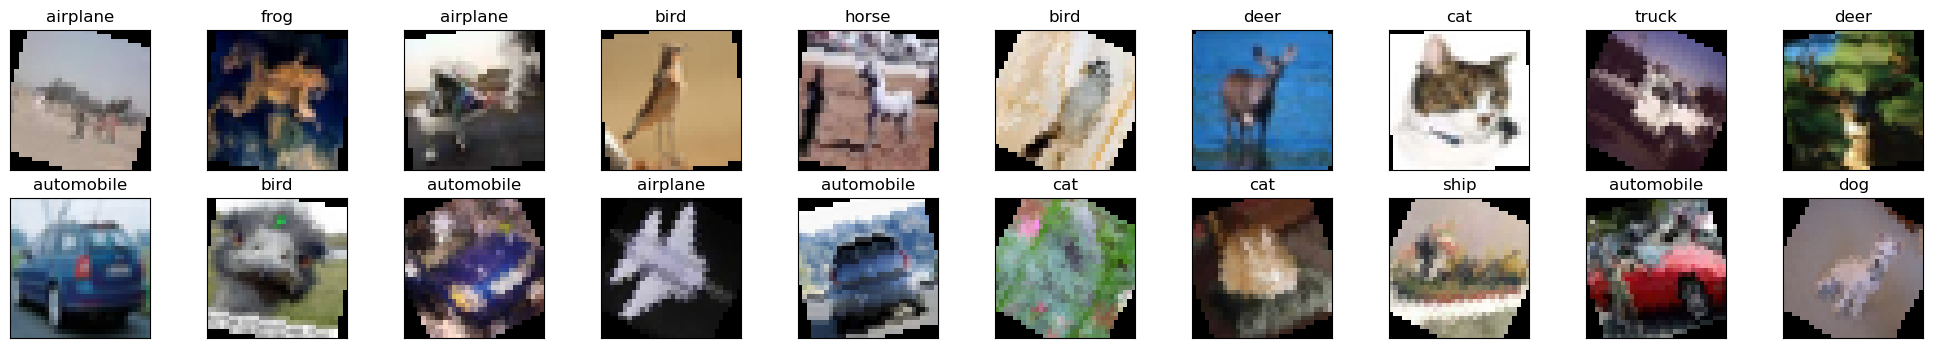

In [68]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(train_data.classes[labels[idx]])

In [53]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.linear = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        self.linear2 = nn.Sequential(
            nn.Linear(512, 10),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = self.linear2(x)
        return x

In [54]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

cuda:0


In [60]:
epochs = 30
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        net.train()
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        pred = torch.max(outputs, 1)[1]
        total_train += labels.size(0)
        correct_train += (pred == labels).sum().item()
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 100 == 0 or i+1 == len(train_loader):
            correct = 0
            total = 0
            net.eval()
            with torch.no_grad():
                for images_test, labels_test in test_loader:
                    images_test, labels_test = images_test.to(device), labels_test.to(device)
                    outputs_test = net(images_test)
                    pred_test = torch.max(outputs_test, 1)[1]
                    total += labels_test.size(0)
                    correct += torch.sum(pred_test == labels_test).item()
            acc = 100 * correct / total
            acc_train = 100 * correct_train / total_train
            print(f'--[{i+1}/{len(train_loader)}\t损失值：{loss.item():.4f}\t训练集正确率：{acc_train:.4f}%\t测试集正确率:{acc:.4f}%]')
            
        

Epoch 1/30
--[100/391	损失值：1.6198	训练集正确率：39.3047%	测试集正确率:41.1800%]
--[200/391	损失值：1.6096	训练集正确率：39.4375%	测试集正确率:41.5200%]
--[300/391	损失值：1.5941	训练集正确率：39.2995%	测试集正确率:42.7300%]
--[391/391	损失值：1.5784	训练集正确率：39.5420%	测试集正确率:42.8300%]
Epoch 2/30
--[100/391	损失值：1.6036	训练集正确率：41.3984%	测试集正确率:43.6400%]
--[200/391	损失值：1.6175	训练集正确率：41.4219%	测试集正确率:44.2200%]
--[300/391	损失值：1.6241	训练集正确率：41.4714%	测试集正确率:44.4600%]
--[391/391	损失值：1.5905	训练集正确率：41.7860%	测试集正确率:44.3100%]
Epoch 3/30
--[100/391	损失值：1.5371	训练集正确率：42.4297%	测试集正确率:45.5000%]
--[200/391	损失值：1.5504	训练集正确率：42.6250%	测试集正确率:45.2400%]
--[300/391	损失值：1.5274	训练集正确率：42.6953%	测试集正确率:45.8100%]
--[391/391	损失值：1.4292	训练集正确率：42.9340%	测试集正确率:46.1400%]
Epoch 4/30
--[100/391	损失值：1.4145	训练集正确率：43.7969%	测试集正确率:46.2300%]
--[200/391	损失值：1.6746	训练集正确率：44.0039%	测试集正确率:46.8700%]
--[300/391	损失值：1.5287	训练集正确率：44.2214%	测试集正确率:47.2400%]
--[391/391	损失值：1.5143	训练集正确率：44.4060%	测试集正确率:47.7200%]
Epoch 5/30
--[100/391	损失值：1.4639	训练集正确率：44.6016%	测试集正确率:47.8700%]
--[200/391